In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import sys

from simplerl import (DDPGAgent, 
                      DDPGNet,
                      OrnsteinUhlenbeckProcess, 
                      ConstantScheduler, 
                      LinearScheduler,
                      train,
                      GymMonitorHook)

%matplotlib inline

In [20]:
def plot_raw_scores(ax, monitor_hooks, window = 100):
    scores = [m.scores for m in monitor_hooks]
    min_eps_len = min([len(s) for s in scores])
    running_avgs = [pd.Series(s[:min_eps_len]).rolling(window, min_periods = 1).mean() 
                    for s in scores]
    
    for avg in running_avgs:
        ax.plot(avg)

def plot_scores(ax, monitor_hooks, window = 100):
    scores = [m.scores for m in monitor_hooks]
    min_eps_len = min([len(s) for s in scores])
    running_avgs = [pd.Series(s[:min_eps_len]).rolling(window, min_periods = 1).mean() 
                    for s in scores]
    
    average = np.array(running_avgs).mean(axis = 0)
    median = np.median(np.array(running_avgs), axis = 0)
    max_band = np.array(running_avgs).max(axis = 0)
    min_band = np.array(running_avgs).min(axis = 0)
    
    ax.plot(average, label = 'Mean Running Score')
    ax.plot(median, label = 'Median Running Score')
    ax.fill_between(np.arange(min_eps_len) + 1, 
                    min_band, max_band,
                    alpha = 0.5)

In [2]:
env_fn = lambda: gym.make('LunarLanderContinuous-v2')
model_fn = lambda: DDPGNet(8, 2, (256, 128), action_scale = 1.0)
noise_fn = lambda: OrnsteinUhlenbeckProcess((2, ), ConstantScheduler(0.2))

In [4]:
monitors = []

for i in range(5):
    agent = DDPGAgent(env_fn = env_fn, 
                      model_fn = model_fn,
                      n_actors = 1,
                      action_range = 1.0,
                      gamma = 0.99,
                      exploration_noise = noise_fn,
                      batch_size = 64,
                      n_steps = 1,
                      replay_memory = 100000,
                      use_per = False,
                      replay_start = 1000,
                      parameter_tau = 1e-3,
                      buffer_tau = 1e-3,
                      optimizer = optim.Adam,
                      policy_learning_rate = 1e-4,
                      critic_learning_rate = 1e-3,
                      weight_decay = 1e-5,
                      clip_gradients = 5.0,
                      update_freq = 4)

    monitors.append(GymMonitorHook(verbose = 50, vector_env = True))
    
    agent.train()
    print('Training Agent {}'.format(i + 1))
    train(agent, agent.env, train_steps = 500000, hooks = [monitors[-1]], vector_env = True)
    print('')

Training Agent 1
Episode 50 | Time Steps: 93 | Average Score: -419.44
Episode 100 | Time Steps: 335 | Average Score: -457.53
Episode 150 | Time Steps: 85 | Average Score: -450.74
Episode 200 | Time Steps: 182 | Average Score: -464.97
Episode 250 | Time Steps: 123 | Average Score: -388.49
Episode 300 | Time Steps: 217 | Average Score: -217.84
Episode 350 | Time Steps: 1000 | Average Score: -184.07
Episode 400 | Time Steps: 121 | Average Score: -188.06
Episode 450 | Time Steps: 152 | Average Score: -177.81
Episode 500 | Time Steps: 614 | Average Score: -163.11
Episode 550 | Time Steps: 134 | Average Score: -166.12
Episode 600 | Time Steps: 1000 | Average Score: -163.87
Episode 650 | Time Steps: 1000 | Average Score: -136.22
Episode 700 | Time Steps: 361 | Average Score: -61.08
Episode 750 | Time Steps: 180 | Average Score: 8.44
Episode 800 | Time Steps: 507 | Average Score: 66.46
Episode 850 | Time Steps: 356 | Average Score: 112.28
Episode 900 | Time Steps: 466 | Average Score: 125.35
E

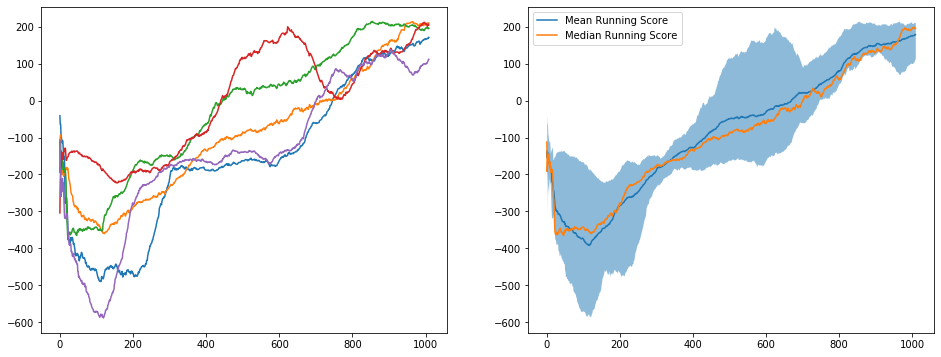

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
plot_raw_scores(ax[0], monitors)
plot_scores(ax[1], monitors)
plt.legend(loc = 'upper left')
plt.show()

In [5]:
monitors = []

for i in range(5):
    agent = DDPGAgent(env_fn = env_fn, 
                      model_fn = model_fn,
                      n_actors = 16,
                      action_range = 1.0,
                      gamma = 0.99,
                      exploration_noise = noise_fn,
                      batch_size = 64,
                      n_steps = 5,
                      replay_memory = 100000,
                      use_per = True,
                      alpha = 0.6,
                      beta = LinearScheduler(0.4, 1.0, 100000),
                      replay_start = 1000,
                      parameter_tau = 1e-3,
                      buffer_tau = 1e-3,
                      optimizer = optim.Adam,
                      policy_learning_rate = 1e-4,
                      critic_learning_rate = 1e-3,
                      weight_decay = 1e-5,
                      clip_gradients = 5.0,
                      update_freq = 4)

    monitors.append(GymMonitorHook(verbose = 50, vector_env = True))
    
    agent.train()
    print('Training Agent {}'.format(i + 1))
    train(agent, agent.env, train_steps = 250000, hooks = [monitors[-1]], vector_env = True)
    print('')

Training Agent 1
Episode 50 | Time Steps: 138 | Average Score: -196.72
Episode 100 | Time Steps: 251 | Average Score: -243.55
Episode 150 | Time Steps: 89 | Average Score: -263.04
Episode 200 | Time Steps: 141 | Average Score: -199.67
Episode 250 | Time Steps: 67 | Average Score: -167.04
Episode 300 | Time Steps: 221 | Average Score: -166.57
Episode 350 | Time Steps: 604 | Average Score: -92.59
Episode 400 | Time Steps: 428 | Average Score: 69.09
Episode 450 | Time Steps: 358 | Average Score: 142.29
Episode 500 | Time Steps: 247 | Average Score: 149.54
Episode 550 | Time Steps: 257 | Average Score: 180.24
Episode 600 | Time Steps: 237 | Average Score: 195.86
Episode 650 | Time Steps: 245 | Average Score: 210.05
Episode 700 | Time Steps: 191 | Average Score: 219.13
Episode 750 | Time Steps: 223 | Average Score: 213.33
Episode 800 | Time Steps: 150 | Average Score: 215.35
Episode 850 | Time Steps: 224 | Average Score: 231.06
Episode 900 | Time Steps: 177 | Average Score: 233.00
Episode 9

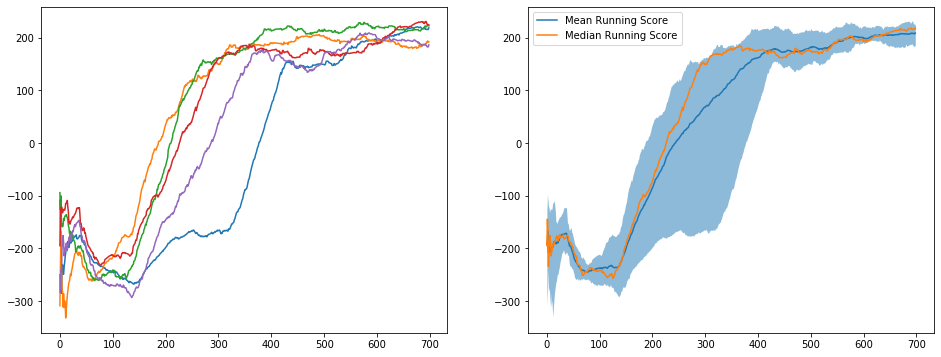

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
plot_raw_scores(ax[0], monitors)
plot_scores(ax[1], monitors)
plt.legend(loc = 'upper left')
plt.show()